In [373]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from vae_earlystopping import EarlyStopping
from torch.utils.data import  DataLoader, Dataset
from model_vae import CVAE,cvae_loss_each,cvae_loss_optimized,cvae_loss
import pandas as pd
import matplotlib.pyplot as plt

x_data = np.load('./data/metal.npy',allow_pickle = True)
c_data = np.load('./data/reaction.npy',allow_pickle = True)
sup_data = np.load('./data/support.npy',allow_pickle=True)


In [374]:
## train,test,validation_data 만들기
from sklearn.model_selection import train_test_split
x_train,x_test,c_train,c_test = train_test_split(x_data,c_data,test_size = 0.4,shuffle = False)
x_val,x_test,c_val,c_test = train_test_split(x_test,c_test,test_size = 0.5,shuffle= False)
print(x_train.shape,c_val.shape,x_test.shape) #0.6 #0.2 #0.2로 데이터 분류


(3544, 24) (1182, 9) (1182, 24)


# 데이터 scaler로 정리하기

In [375]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()
scaler_c = StandardScaler()
x_train_s = scaler_x.fit_transform(x_train)
x_val_s = scaler_x.transform(x_val)
x_test_s = scaler_x.transform(x_test)
c_train_s = scaler_c.fit_transform(c_train)
c_val_s = scaler_c.transform(c_val)
c_test_s = scaler_c.transform(c_test)

## scaler데이터 numpy에서 tensor로 바꾸기

In [376]:
x_train_s = torch.tensor(x_train_s, dtype=torch.float32)
x_val_s   = torch.tensor(x_val_s,   dtype=torch.float32)
x_test_s  = torch.tensor(x_test_s,  dtype=torch.float32)

c_train_s = torch.tensor(c_train_s, dtype=torch.float32)
c_val_s   = torch.tensor(c_val_s,   dtype=torch.float32)
c_test_s  = torch.tensor(c_test_s,  dtype=torch.float32)

In [377]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64
learning_rate = 1e-3
z_dim = 16
epochs = 200
train_dataset = TensorDataset(x_train_s,c_train_s)
val_dataset = TensorDataset(x_val_s,c_val_s)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle = True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle = False)

In [378]:
x=torch.tensor([[1,2]])
y=torch.tensor([[3,4]])
c = torch.cat((x,y),dim =1)
c

tensor([[1, 2, 3, 4]])

## 여기서 보면 dim=0이면 행을 늘리는 방향으로 붙이는 거니깐, 
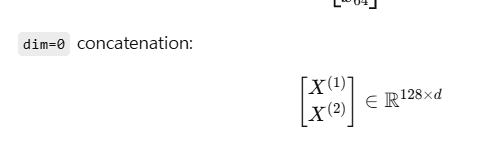

## tensor관련 연습(dim=0에 대해서)

In [379]:
x_dim = x_train_s.shape[1]
c_dim = c_train_s.shape[1]


In [380]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CVAE(x_dim,c_dim,z_dim = 16).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

## 학습방법

In [381]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 모델 초기화
model = CVAE(x_dim=x_dim, c_dim=c_dim, z_dim=z_dim).to(device)

# Optimizer 설정 (Adam이 일반적으로 가장 무난합니다)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(optimizer.zero_grad())

None


In [382]:
from torch.utils.data import TensorDataset, DataLoader

# (1) test_loader (x_test, c_test가 torch tensor로 만들어진 뒤에 실행)
test_loader = DataLoader(
    TensorDataset(x_test_s, c_test_s),
    batch_size=128,
    shuffle=False
)

train_losses = []
val_losses = []

early = EarlyStopping(patience=30, min_delta=1e-4)
best_epoch = 0

for epoch in range(1, epochs + 1):
    # --- 학습 ---
    model.train()
    train_total_loss = 0.0

    for batch_x, batch_c in train_loader:
        batch_x = batch_x.to(device)
        batch_c = batch_c.to(device)

        optimizer.zero_grad()
        x_hat, mu, logvar = model(batch_x, batch_c)

        loss, recon, kl = cvae_loss(x_hat, batch_x, mu, logvar, beta=0.01)

        loss.backward()
        optimizer.step()

        train_total_loss += loss.item()

    avg_train_loss = train_total_loss / len(train_loader)

    # --- 검증 ---
    model.eval()
    val_total_loss = 0.0
    with torch.no_grad():
        for v_x, v_c in val_loader:
            v_x = v_x.to(device)
            v_c = v_c.to(device)

            v_hat, v_mu, v_logvar = model(v_x, v_c)
            v_loss, _, _ = cvae_loss(v_hat, v_x, v_mu, v_logvar, beta=0.01)
            val_total_loss += v_loss.item()

    avg_val_loss = val_total_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch [{epoch}/{epochs}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # --- EarlyStopping 체크 ---
    stop = early.step(avg_val_loss, model)
    if early.best_state is not None and avg_val_loss == early.best:
        best_epoch = epoch

    if stop:
        print(f"Early stopping at epoch {epoch}. Best epoch: {best_epoch}, Best val loss: {early.best:.6f}")
        break

# ===== 학습 끝: best 모델 weight로 복원 =====
if early.best_state is not None:
    model.load_state_dict(early.best_state)
model = model.to(device)
model.eval()

# ===== (2) 그 상태에서 prediction =====
x_hat_list = []
mu_list = []
logvar_list = []

with torch.no_grad():
    for x_t, c_t in test_loader:
        x_t = x_t.to(device)
        c_t = c_t.to(device)

        x_hat, mu, logvar = model(x_t, c_t)

        x_hat_list.append(x_hat.detach().cpu())
        mu_list.append(mu.detach().cpu())
        logvar_list.append(logvar.detach().cpu())

x_hat_test = torch.cat(x_hat_list, dim=0)     # (N_test, x_dim)
mu_test = torch.cat(mu_list, dim=0)           # (N_test, z_dim)
logvar_test = torch.cat(logvar_list, dim=0)   # (N_test, z_dim)

print("x_hat_test shape:", x_hat_test.shape)

# (선택) test recon MSE 확인
x_true_test = x_test_s.detach().cpu()
test_mse = F.mse_loss(x_hat_test, x_true_test).item()
print("test recon MSE:", test_mse)


Epoch [1/200] Train Loss: 0.645942 | Val Loss: 7.335423
Epoch [20/200] Train Loss: 0.088447 | Val Loss: 0.779175
Epoch [40/200] Train Loss: 0.076757 | Val Loss: 0.727539
Early stopping at epoch 52. Best epoch: 22, Best val loss: 0.638811
x_hat_test shape: torch.Size([1182, 24])
test recon MSE: 0.4883968234062195


In [383]:
for i in range(len(x_hat_list)):
    print(x_hat_list[i].shape)

torch.Size([128, 24])
torch.Size([128, 24])
torch.Size([128, 24])
torch.Size([128, 24])
torch.Size([128, 24])
torch.Size([128, 24])
torch.Size([128, 24])
torch.Size([128, 24])
torch.Size([128, 24])
torch.Size([30, 24])


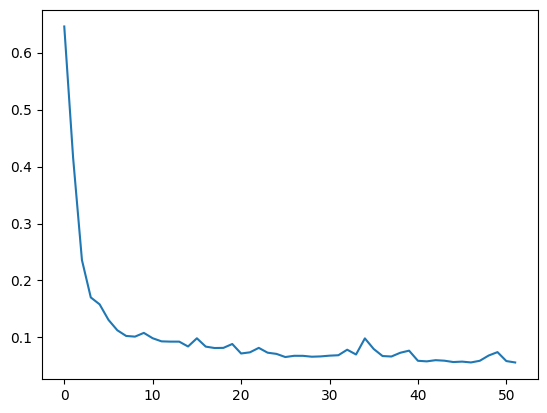

In [384]:
import matplotlib.pyplot as plt
x_values= torch.arange(len(train_losses))
plt.plot(x_values,train_losses)
# plt.plot(x_values,val_losses)

# 실제값과 예측값의 비교

In [385]:
x_true_test_np = x_true_test.detach().cpu().numpy()
x_test_np = x_hat_test.detach().cpu().numpy()
x_true_test = scaler_x.inverse_transform(x_true_test_np)
x_hat_test = scaler_x.inverse_transform(x_test_np)

In [386]:
x_hat_test.shape

(1182, 24)

In [387]:
df = pd.read_csv('211210-DRM-total.csv')
metal_columns = df.iloc[:,1:25].columns
metal_columns

Index(['Perovskite', 'Co', 'Ba', 'Ca', 'Cu', 'Ce', 'Mn', 'La', 'Ni', 'Ag',
       'Pt', 'Mg', 'Ir', 'Au', 'K', 'Li', 'Ru', 'Rh', 'Fe', 'Pr', 'Pd', 'Sr',
       'Y', 'Zr'],
      dtype='object')

In [388]:
x_true_test[1181].shape

(24,)

(1182, 24) (1182, 24)


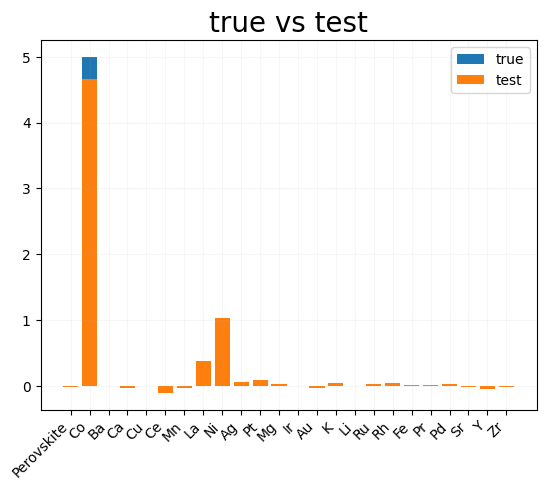

In [389]:
print(x_true_test.shape,x_true_test.shape)
plt.bar(metal_columns, x_true_test[0],label = 'true')
plt.bar(metal_columns, x_hat_test[0], label = 'test')
plt.legend()
plt.xticks(rotation=45, ha = 'right')
plt.grid(alpha =0.1)
plt.title(f'true vs test',fontsize = 20)
plt.show()